In [19]:
import torch
import torch.nn as nn
from lienp.liegroups import *
from lienp.modules import *
from lienp.modules.lieconv import SeparableLieConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GridLieCNP(nn.Module):
    """Grid LieGroup Convolutional Conditional Neural Process
    """
    def __init__(self, channel=1, group=T(2)):
        super().__init__()
        self.channel = channel
        self.group = group

        self.conv_theta = LieConv(channel, 128, group=group,
                                  num_nbhd=81, sampling_fraction=1., fill=1 / 10,
                                  use_bn=True, mean=True, cache=True)

        self.cnn = nn.Sequential(
            Apply(nn.Linear(128 * 2, 128), dim=1),
            ResBlock(128, 128, mean=True, group=group),
            ResBlock(128, 128, mean=True, group=group),
            ResBlock(128, 128, mean=True, group=group),
            ResBlock(128, 128, mean=True, group=group),
            Apply(nn.Linear(128, 2 * channel))
        )
        self.pos = nn.Softplus()

    def forward(self, x):
        B, C, W, H = x.shape
        ctx_coords, ctx_density, ctx_signal, ctx_mask = self.get_masked_image(x)
        lifted_ctx_coords, lifted_ctx_density, lifted_ctx_mask = self.group.lift((ctx_coords, ctx_density, ctx_mask), 1)
        lifted_ctx_signal, _ = self.group.expand_like(ctx_signal, ctx_mask, lifted_ctx_coords)

        lifted_ctx_coords, density_prime, lifted_ctx_mask = self.conv_theta((lifted_ctx_coords, lifted_ctx_density, lifted_ctx_mask))
        _, signal_prime, _ = self.conv_theta((lifted_ctx_coords, lifted_ctx_signal, lifted_ctx_mask))

        ctx_h = torch.cat([density_prime, signal_prime], -1)
        _, f, _ = self.cnn((lifted_ctx_coords, ctx_h, lifted_ctx_mask))
        mean, std = f.split(self.channel, -1)

        mean = mean.squeeze(-1)
        std = self.pos(std).squeeze(-1)
        return mean, std.diag_embed(), ctx_density.reshape(B, H, W, C).permute(0, 3, 1, 2)

    def predict(self, x, ctx_coords, ctx_density, ctx_signal, ctx_mask):
        B, C, W, H = x.shape
        lifted_ctx_coords, lifted_ctx_density, lifted_ctx_mask = self.group.lift((ctx_coords, ctx_density, ctx_mask), 1)
        lifted_ctx_signal, _ = self.group.expand_like(ctx_signal, ctx_mask, lifted_ctx_coords)

        lifted_ctx_coords, density_prime, lifted_ctx_mask = self.conv_theta((lifted_ctx_coords, lifted_ctx_density, lifted_ctx_mask))
        _, signal_prime, _ = self.conv_theta((lifted_ctx_coords, lifted_ctx_signal, lifted_ctx_mask))

        ctx_h = torch.cat([density_prime, signal_prime], -1)
        _, f, _ = self.cnn((lifted_ctx_coords, ctx_h, lifted_ctx_mask))
        mean, std = f.split(self.channel, -1)

        mean = mean.squeeze(-1)
        std = self.pos(std).squeeze(-1)
        return mean, std.diag_embed(), ctx_density.reshape(B, H, W, C).permute(0, 3, 1, 2)

    def get_masked_image(self, img):
        """Get Context image and Target image

        Args:
            img (FloatTensor): image tensor (B, C, W, H)

        Returns:
            ctx_coords (FloatTensor): [B, W*H, 2]
            ctx_density (FloatTensor): [B, W*H, C]
            ctx_signal (FloatTensor): [B, W*H, C]

        """
        B, C, H, W = img.shape
        total_size = W * H

        if self.training:
            # uniform mask #FIXME
            ctx_size = torch.empty(B, 1, 1, 1).uniform_(total_size / 100, total_size / 2)
            # Broadcast to channel-axis [B, 1, W, H] -> [B，C, W, H]
            ctx_mask = img.new_empty(B, 1, W, H).bernoulli_(p=ctx_size / total_size).repeat(1, C, 1, 1)
        else:
            # box mask
            ctx_size = torch.empty(B, 1, 1, 1).uniform_(total_size / 100, total_size / 2)
            # Broadcast to channel-axis [B, 1, W, H] -> [B，C, W, H]
            ctx_mask = img.new_empty(B, 1, W, H).bernoulli_(p=ctx_size / total_size).repeat(1, C, 1, 1)

        #  [B, C, W, H] -> [B, W, H, C] -> [B, W*H, C]
        ctx_signal = (ctx_mask * img).permute(0, 2, 3, 1).reshape(B, -1, C)

        ctx_coords = torch.linspace(-W / 2., W / 2., W, device=img.device)
        # [B, W*H, 2]
        ctx_coords = torch.stack(torch.meshgrid([ctx_coords, ctx_coords]), -1).reshape(1, -1, 2).repeat(B, 1, 1)
        ctx_density = ctx_mask.reshape(B, -1, C)
        # ctx_mask = torch.ones(*ctx_signal.shape[:2], device=img.device).bool()
        ctx_mask = img.new_ones(B, W * H, dtype=torch.bool)
        return ctx_coords, ctx_density, ctx_signal, ctx_mask


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, group=T(2), mean=False, r=2.):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.group = group

        self.conv = nn.Sequential(
            SeparableLieConv(in_channels, out_channels, num_nbhd=81, fill=1 / 15, sample=1., group=group, r=r, use_bn=False, mean=True),
            Apply(nn.ReLU(inplace=True), dim=1),
            SeparableLieConv(out_channels, out_channels, num_nbhd=81, fill=1 / 15, sample=1., group=group, r=r, use_bn=False, mean=True)
        )
        self.final_relu = nn.ReLU(inplace=True)

    def forward(self, x):
        shortcut = x
        coords, values, mask = self.conv(x)
        values = self.final_relu(values + shortcut[1])
        return coords, values, mask

In [20]:
from torchvision.utils import make_grid, save_image
import torch
from torchvision.transforms import functional as F
from torchvision import transforms as tf
from lienp.datasets.clockdigit import ClockDigit
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
    
test_tf = tf.Compose([
    tf.Pad(16),
    tf.Lambda(lambda x: tf.functional.affine(x, 5, (0, 0), 2.0, 0)),
    tf.ToTensor()
])

transforms = tf.Compose([
            tf.Pad(16),
            tf.RandomAffine(degrees=90, scale=(0.6, 0.9)),
            tf.ToTensor()
        ])
batch_size = 1
testset = ClockDigit("~/data/clockdigits", download=True, transform=transforms)
dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [18]:
rxso2 = GridLieCNP(channel=1, group=RxSO2())
rxso2.load_state_dict(torch.load("weights/2dreg/RxSO2.pth"))
so2 = GridLieCNP(channel=1, group=SO2())
so2.load_state_dict(torch.load("weights/2dreg/SO2.pth"))
se2 = GridLieCNP(channel=1, group=SE2())
se2.load_state_dict(torch.load("weights/2dreg/SE2.pth"))
t2 = GridLieCNP(channel=1, group=T(2))
t2.load_state_dict(torch.load("weights/2dreg/T2.pth"))

rxso2.eval()
so2.eval()
se2.eval()
t2.eval()

rxso2_result = []
so2_result = []
se2_result = []
t2_result = []

for i in range(1):
    imgs = iter(dl).next()[0]
    with torch.no_grad():
        a = t2(imgs)
        t2_result.append(MultivariateNormal(a[0], scale_tril=a[1]).log_prob(imgs.reshape(batch_size, -1)))
        
        a = so2(imgs)
        so2_result.append(MultivariateNormal(a[0], scale_tril=a[1]).log_prob(imgs.reshape(batch_size, -1)))
        
        a = se2(imgs)
        se2_result.append(MultivariateNormal(a[0], scale_tril=a[1]).log_prob(imgs.reshape(batch_size, -1)))
        
        a = rxso2(imgs)
        rxso2_result.append(MultivariateNormal(a[0], scale_tril=a[1]).log_prob(imgs.reshape(batch_size, -1)))

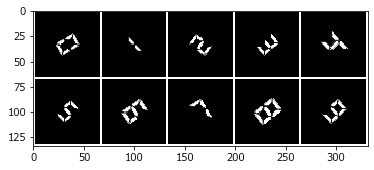

In [47]:
show(make_grid(iter(dl).next()[0], nrow=5, pad_value=1))

In [28]:
from torch.distributions import MultivariateNormal

In [32]:
MultivariateNormal(a[0], scale_tril=a[1]).log_prob(imgs.reshape(batch_size, -1)) / 4096

tensor([1.5564])